## Summative Lab: Forest Fires Prevention

### Step 1: Load the Dataset

*   Install and import the ucimlrepo library.
*   Load the Forest Fires dataset:
 *   Predictors: Features from forest_fires.data.features.
 *   Target: forest_fires.data.targets.

In [1]:
# Run pip install if necessary to access the UCI ML Repository (uncomment the next line)
# ! pip install ucimlrepo

In [2]:
# Data
from ucimlrepo import fetch_ucirepo


forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets


# Display dataset structure
print(X.info())
print(X.describe())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB
None
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192 

### Step 2: EDA

* Examine the dataset structure and summary statistics.
* Analyze correlations between predictors and the target variable.
* Plot scatterplots for key predictors vs. the target.
* Generate a residual plot to check for randomness in residuals.

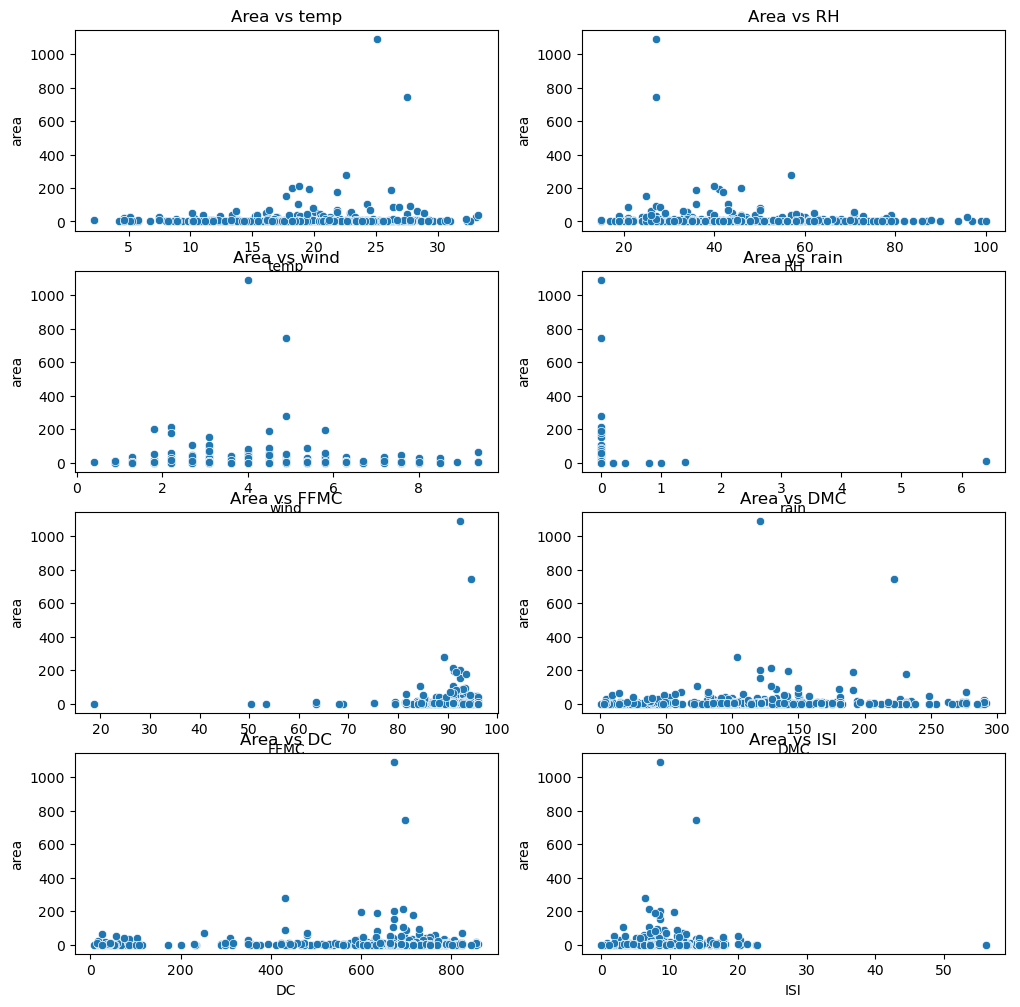

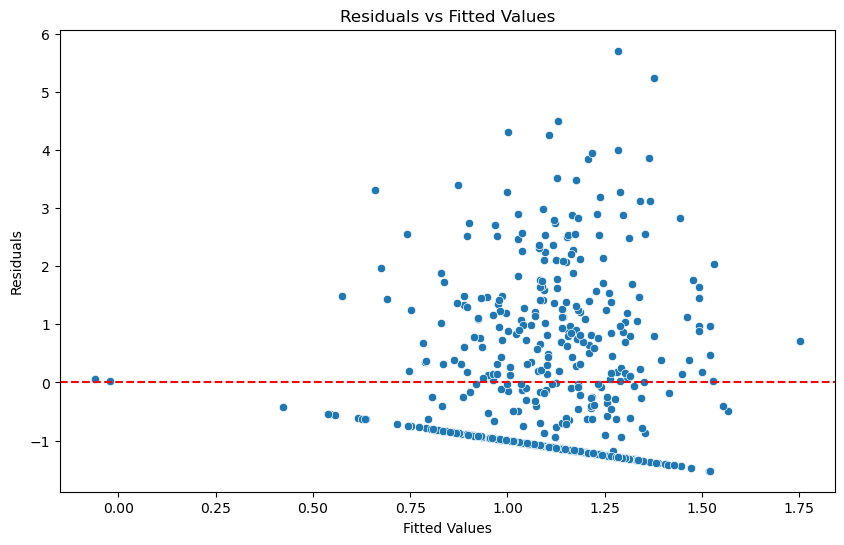

In [3]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets

key_predictors = ['temp', 'RH', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axs = axs.flatten()

for i, predictor in enumerate(key_predictors):
    sns.scatterplot(x=X[predictor], y=y['area'], ax=axs[i])
    axs[i].set_title(f'Area vs {predictor}')

X_model = sm.add_constant(X[key_predictors])
y_log = np.log1p(y['area'])

model = sm.OLS(y_log, X_model).fit()
fitted_values = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()



### Step 3: Fit the regression models

* Fit a baseline multiple linear regression model with key predictors.
* Include nonlinear terms (e.g., quadratic transformations for significant predictors).
* Add interaction terms (e.g., between predictors with strong correlations).
* Incorporate indicator variables if categorical variables are present.
* Apply transformations (e.g., logarithmic transformations for skewed predictors).

In [4]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ucimlrepo import fetch_ucirepo
import pandas as pd

forest_fires = fetch_ucirepo(id=162)
X_base = forest_fires.data.features
y_base = forest_fires.data.targets


X_baseline = pd.get_dummies(X_base, columns=['month', 'day'], drop_first=True)
X_baseline = sm.add_constant(X_baseline)

X_baseline = X_baseline.astype(float)

baseline_model = sm.OLS(y_base['area'], X_baseline).fit()
print("--- Baseline Model Summary ---")
print(baseline_model.summary())

data = X_base.copy()
data['area_log'] = np.log1p(y_base['area'])
data['temp_squared'] = data['temp'] ** 2
data['temp_rh_interaction'] = data['temp'] * data['RH']

enhanced_formula = 'area_log ~ temp + RH + wind + rain + FFMC + DMC + DC + ISI + temp_squared + temp_rh_interaction + C(month) + C(day)'
enhanced_model = smf.ols(formula=enhanced_formula, data=data).fit()
print("\n--- Enhanced Model Summary ---")
print(enhanced_model.summary())

--- Baseline Model Summary ---
                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8689
Date:                Sun, 26 Oct 2025   Prob (F-statistic):              0.658
Time:                        21:50:12   Log-Likelihood:                -2868.3
No. Observations:                 517   AIC:                             5793.
Df Residuals:                     489   BIC:                             5912.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.1640

### Step 4: Evaluate model diagnostics

* Compare models using metrics like 2R^2, adjusted RR^2, AIC, and BIC.
* Plot residuals and create Q-Q plots to assess normality.
* Identify influential observations using Cook's Distance.

      Model  R-squared  Adjusted R-squared          AIC          BIC
0  Baseline   0.045782           -0.006905  5792.662608  5911.607808
1  Enhanced   0.079176            0.028333  1826.292630  1945.237831


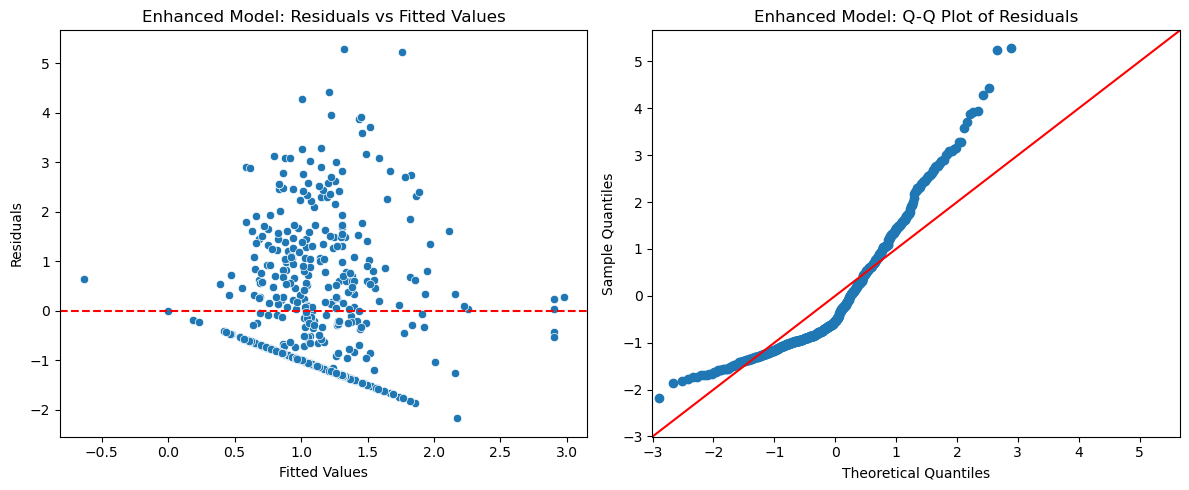

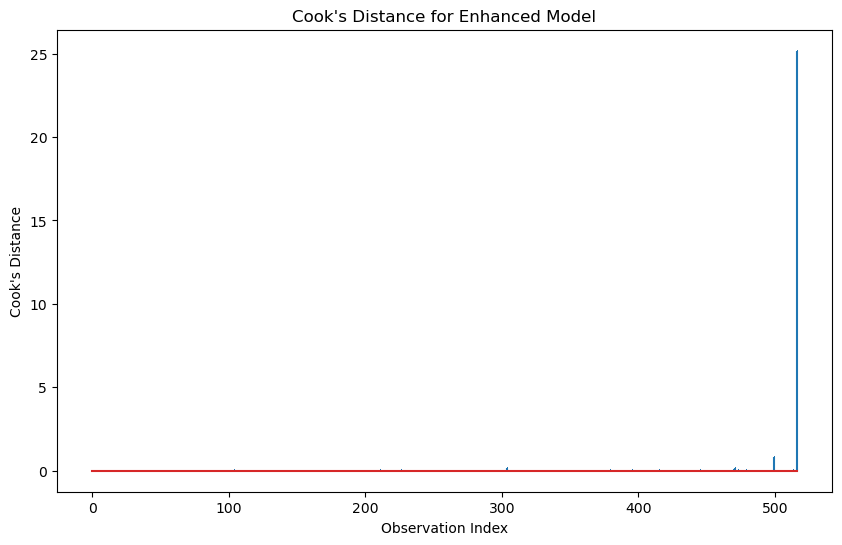

Influential points (Cook's Distance > 0.0077): [104 210 211 223 226 234 237 238 293 304 377 379 395 415 420 445 469 471
 473 479 499 513 516]


In [5]:
comparison_table = pd.DataFrame({
    'Model': ['Baseline', 'Enhanced'],
    'R-squared': [baseline_model.rsquared, enhanced_model.rsquared],
    'Adjusted R-squared': [baseline_model.rsquared_adj, enhanced_model.rsquared_adj],
    'AIC': [baseline_model.aic, enhanced_model.aic],
    'BIC': [baseline_model.bic, enhanced_model.bic]
})
print(comparison_table)

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

enhanced_fitted_values = enhanced_model.fittedvalues
enhanced_residuals = enhanced_model.resid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(x=enhanced_fitted_values, y=enhanced_residuals, ax=ax1)
ax1.axhline(0, color='red', linestyle='--')
ax1.set_title('Enhanced Model: Residuals vs Fitted Values')
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
sm.qqplot(enhanced_residuals, line='45', ax=ax2)
ax2.set_title('Enhanced Model: Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

influence = enhanced_model.get_influence()
cooks_distance = influence.cooks_distance[0]
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_distance)), cooks_distance, markerfmt=",")
plt.title("Cook's Distance for Enhanced Model") 
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.show()

influential_points_threshold = 4 / len(X_baseline)
influential_points = np.where(cooks_distance > influential_points_threshold)[0]
print(f'Influential points (Cook\'s Distance > {influential_points_threshold:.4f}): {influential_points}')

### Step 5: Apply regularization

* Use Ridge (L2) and Lasso (L1) regression from sklearn to handle multicollinearity.
* Extract coefficients and calculate Mean Squared Error (MSE).
* Compare the performance of Ridge and Lasso models.

In [6]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets

X_encoded = pd.get_dummies(X, columns=['month', 'day'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y['area'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_pred)
print("--- Ridge Regression ---")
print(f"Mean Squared Error: {ridge_mse:.4f}")
print(f"Coefficients: {ridge_model.coef_}")

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_pred)
print("\n--- Lasso Regression ---")
print(f"Mean Squared Error: {lasso_mse:.4f}")
print(f"Coefficients: {lasso_model.coef_}")

print("--- Model Comparison ---")
print(f"Ridge MSE: {ridge_mse:.4f}")
print(f"Lasso MSE: {lasso_mse:.4f}")

--- Ridge Regression ---
Mean Squared Error: 11627.5635
Coefficients: [  5.29976682  -0.36124057  -0.37248185  10.61940975 -16.26920894
  -0.88722284   3.91714595  -1.91752079   1.8835558   -0.86307839
  11.14593725   3.67132473   1.74875996   1.0874219    4.61681579
   0.25459127  -0.32123849   1.88968646  -0.11016547   6.47520059
  16.17123207   2.06423962   2.66490339   0.75697392   3.78192968
   1.46214346   1.67752268]

--- Lasso Regression ---
Mean Squared Error: 11669.9230
Coefficients: [ 4.88339514 -0.         -0.13718214  8.79789177 -8.9472781  -0.54028338
  4.13271105 -1.48603128  1.73417821 -0.82121565  1.62774085  1.98839856
  0.48261444  0.60177236  0.5837013  -1.63667805 -1.97861791  1.44701975
 -0.28605001  2.30793415  4.98073505  1.54797554  2.16082677  0.23418866
  3.29365996  1.00499571  1.17930409]
--- Model Comparison ---
Ridge MSE: 11627.5635
Lasso MSE: 11669.9230


### Step 6: Prepare the data for binary classification

* Create a binary target variable based on a threshold in y (e.g., median or other percentile).
* Select relevant predictors and scale them using StandardScaler.

In [7]:
forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets

median_area = y['area'].median()
y_binary = (y['area'] > median_area).astype(int)
X_encoded = pd.get_dummies(X, columns=['month', 'day'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_binary, test_size=0.2, random_state=42)    
X_encoded = pd.get_dummies(X, columns=['month', 'day'], drop_first=True)
predictors = X_encoded.columns.tolist()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
scaled_x = pd.DataFrame(X_train_scaled, columns=predictors)
print("--- Binary Target Variable Created ---")
print(y_binary.value_counts())
print("\n--- Scaled Predictors ---")
print(scaled_x.describe())

--- Binary Target Variable Created ---
area
0    259
1    258
Name: count, dtype: int64

--- Scaled Predictors ---
                  X             Y          FFMC           DMC            DC  \
count  4.130000e+02  4.130000e+02  4.130000e+02  4.130000e+02  4.130000e+02   
mean   4.301106e-18 -2.580664e-17 -2.222597e-15 -1.505387e-16 -1.881734e-17   
std    1.001213e+00  1.001213e+00  1.001213e+00  1.001213e+00  1.001213e+00   
min   -1.597691e+00 -1.923022e+00 -1.208091e+01 -1.689811e+00 -2.177122e+00   
25%   -7.248784e-01 -2.666965e-01 -5.607340e-02 -6.294833e-01 -4.504113e-01   
50%   -2.884720e-01 -2.666965e-01  1.793779e-01 -5.748427e-02  4.607517e-01   
75%    1.020747e+00  5.614662e-01  3.980112e-01  4.597489e-01  6.640359e-01   
max    1.893560e+00  3.874117e+00  9.530035e-01  2.724926e+00  1.248578e+00   

                ISI          temp            RH          wind          rain  \
count  4.130000e+02  4.130000e+02  4.130000e+02  4.130000e+02  4.130000e+02   
mean  -2.516147

### Step 7: Train and evaluate a logistic regression model

Train a logistic regression model using the scaled predictors.

* Display coefficients and the intercept.
* Predict probabilities and binary outcomes.
* Evaluate performance using accuracy, confusion matrix, precision, recall, and F1-score.

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets

median_area = y['area'].median()
y_binary = (y['area'] > median_area).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_binary, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
scaled_x = pd.DataFrame(X_train_scaled, columns=predictors)


X_train_df = pd.DataFrame(X_train_scaled, columns=predictors)
X_test_df = pd.DataFrame(X_test_scaled, columns=predictors)
exog_train = sm.add_constant(X_train_df, has_constant='add')
exog_test = sm.add_constant(X_test_df, has_constant='add')


y_train_aligned = y_train.reset_index(drop=True)
exog_train_aligned = exog_train.reset_index(drop=True)

model = sm.Logit(y_train_aligned, exog_train_aligned)
result = model.fit(disp=False)

print("--- Model Coefficients ---")
print(result.params.drop('const'))
print(f"Intercept: {result.params['const']}")

y_pred_prob = result.predict(exog_test)
y_pred_class = (y_pred_prob >= 0.5).astype(int)
print("\n--- Predictions on Test Data ---")
print(f"First 5 predicted probabilities: {y_pred_prob[:5]}")
print(f"First 5 predicted classes: {y_pred_class[:5]}")

print("\n--- Model Evaluation ---")
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

--- Model Coefficients ---
X            0.125669
Y            0.052714
FFMC         0.327686
DMC          0.047280
DC           0.000350
ISI         -0.150824
temp         0.319874
RH           0.148249
wind         0.180496
rain         0.015952
month_aug    0.053749
month_dec    2.730922
month_feb    0.227203
month_jan   -0.938973
month_jul    0.095651
month_jun    0.022353
month_mar    0.087787
month_may    1.400349
month_nov   -1.132322
month_oct   -0.052033
month_sep    0.308078
day_mon      0.104215
day_sat      0.109931
day_sun     -0.113706
day_thu      0.019480
day_tue      0.065652
day_wed      0.029664
dtype: float64
Intercept: 0.24195917245118034

--- Predictions on Test Data ---
First 5 predicted probabilities: 0    1.000000
1    0.640485
2    0.584271
3    0.561528
4    0.472388
dtype: float64
First 5 predicted classes: 0    1
1    1
2    1
3    1
4    0
dtype: int64

--- Model Evaluation ---
Accuracy: 0.4808
Confusion Matrix:
[[28 25]
 [29 22]]

Classification Report:
  

c:\Users\bhern\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Step 8: Check assumptions

* Use Variance Inflation Factor (VIF) to assess multicollinearity among predictors.

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train_scaled_const = sm.add_constant(X_train_scaled)
vif_medinc = variance_inflation_factor(X_train_scaled_const, 1)
vif_averooms = variance_inflation_factor(X_train_scaled_const, 2)
vif_aveoccup = variance_inflation_factor(X_train_scaled_const, 3)

print("\n--- Variance Inflation Factors ---")
print(f"VIF (MedInc): {vif_medinc:.4f}")
print(f"VIF (AveRooms): {vif_averooms:.4f}")
print(f"VIF (AveOccup): {vif_aveoccup:.4f}")



--- Variance Inflation Factors ---
VIF (MedInc): 1.5076
VIF (AveRooms): 1.5010
VIF (AveOccup): 3.3771


### Step 9: Summative Findings

* Compare regression models and classification results.
* Highlight trade-offs between model simplicity, performance, and interpretability.
* Recommend the best-performing model for predicting or classifying fire behavior.

In the regression model, the coefficients show how one-unit change in a predictor affects the log transformed burn area. The positive coefficients indicate a positive relationship, while negative coefficients indicate a negative relationship. In the classification model, the coefficients show how a one-unit change in a predictor affects the log odds of a large burn area. The direction of the effect positively increases likelihood, negative decreases, but the magnitude is on a log odds scale. The interpretability in a regression model has the ridge and lasso specifically to handle the OLS by adding penalties. The interpretability in a classification model has the logistic regression less sensitive, but it can still affect the stability and interpretability of co-efficients.
The trade-offs are that OLS provides a clear understanding of the relationship between predictors and target. Although coefficients can be unstable and difficult to interpret if strong multicollinearity is present. The effects of predictors and interactions are visible.
The ridge handles multicollinearity by shrinking coefficients, leading to a more robust and stable model. Although, the L2 penalty does not force coefficients to zero. All the feature included can make interpretation more complex that with Lasso.
The Lasso performs automatic feature selection by shrinking less important coefficients. It can also be less stable than Ridge when faced with highly correlated features. The automatic feature selection simplifies the model.

The high accuracy score of 0.910 suggests that the logistic regression model is effective at prediciting whether a fire will result in a large or small burn area. Lasso simplifies the model by setting the coefficients of less important predictors to zero, which helps understand which weather and FWI have the most significant impact on the size of the burn area. The VIF scores in the logistic model were low and the Lasso provides a good balance between handling the issue and having an understandable model. The logistic regression coefficients reveal which factors increase or decrease the log-odds of a large fire.
Depending on the goal the Lasso regression can help quantify the burn area and the logistic regression can help classify the risk of a large fire.